* 2024-1-14
* 파이토치와 트랜스포머를 활용한 자연어처리와 컴퓨터비전 심층학습

# 6장 2부 순환신경망
* 순환신경망 이론은 아래 유튜브 참고!!!
* 고려대학교 김성범교수님 : https://www.youtube.com/watch?v=006BjyZicCo
* 순환 신경망과 합성곱 신경망을 사용하여 텍스트분류 실습진행

# 6-6 파이토치 RNN
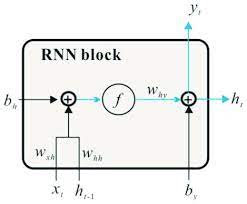
* 출처 : <a href = "https://www.researchgate.net/figure/Simple-RNN-cell-structure-in-hidden-layer-b_fig1_332663947">https://www.researchgate.net/figure/Simple-RNN-cell-structure-in-hidden-layer-b_fig1_332663947</a>

In [13]:
import torch
from torch.nn import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RNN(
    # 입력값의 크기
    input_size = 128,
    # 은닉상태의 크기
    hidden_size = 256,
    # 순환신경망의 층수
    num_layers = 3,
    # 활성화 함수의 종류 -> tanh, relu
    nonlinearity = 'tanh',
    bias = False,
    # True -> [배치크기, 시퀀스 길이, 입력특성크기]
    # False -> [시퀀스 길이, 배치크기, 입력특성크기]
    batch_first = True,
    dropout = 0,
    # 양방향 처리 유무
    bidirectional = True
).to(device)

batch_size = 4
sequence_len = 6
# True = 1
# False = 0
bidirectional = True

inputs = torch.randn(batch_size, sequence_len, 128).to(device)
h_0 = torch.rand(3 * (int(bidirectional) + 1), batch_size, 256).to(device)

outputs, hidden = model(inputs,h_0)
print(outputs.shape)
print(hidden.shape)

torch.Size([4, 6, 512])
torch.Size([6, 4, 256])


In [33]:
from torchinfo import summary
summary(model, (4,6,128))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [4, 6, 512]               983,040
Total params: 983,040
Trainable params: 983,040
Non-trainable params: 0
Total mult-adds (M): 23.59
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 3.93
Estimated Total Size (MB): 4.04

# 6-7 파이토치 LSTM
<img src = "https://velog.velcdn.com/images/soup1997/post/d8e2cbf1-319d-4d65-aa11-4892381354e6/image.png" width = 400 height = 400>
* 출처 : <a href = "https://velog.io/@soup1997/LSTM-Long-Short-Term-Memory">https://velog.io/@soup1997/LSTM-Long-Short-Term-Memory</a>

In [50]:
import torch
from torch import nn

input_size = 128
output_size = 256
num_layers = 3
bidirectional = True
proj_size = 64

model = LSTM(
    input_size = input_size,
    # cell_state_vector_size
    hidden_size = output_size,
    num_layers = num_layers,
    batch_first = True,
    bidirectional = bidirectional,
    # LSTM의 출력 크기를 제어 hidden_vector_size
    # intel의 oneDNN라이브러리에서는 작동안됨
    # proj_size = proj_size
)

batch_size = 4
sequence_len = 6

inputs = torch.randn(batch_size, sequence_len, input_size)
h_0 = torch.rand(
    num_layers * (int(bidirectional) + 1),
    batch_size,
    output_size
    # proj_size if proj_size > 0 else output_size
)
c_0 = torch.rand(num_layers * (int(bidirectional) + 1), batch_size, output_size)

outputs, (h_n, c_n) = model(inputs, (h_0,c_0))

print(outputs.shape)
print(h_n.shape)
print(c_n.shape)

torch.Size([4, 6, 512])
torch.Size([6, 4, 256])
torch.Size([6, 4, 256])


In [52]:
from torchinfo import summary
summary(model, (4,6,128))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [4, 6, 512]               3,944,448
Total params: 3,944,448
Trainable params: 3,944,448
Non-trainable params: 0
Total mult-adds (M): 94.67
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 15.78
Estimated Total Size (MB): 15.89

## 6-7-1 lstm>dense구현(책 외 내용)

In [113]:
from torch import nn
from torchinfo import summary

class basicLSTM(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers,
                 batch_first, 
                 bidirectional,
                 seq_len,
                 device):
        
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size = input_size,
                       hidden_size = hidden_size,
                       num_layers = num_layers,
                       batch_first = batch_first,
                       bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_size,1)
        self.device = device
    
    def forward(self,x):
        '''
        x = (batch_size, seq_len, input_dim)
        '''
        # 텐서 위치 오류(gpu or cpu) 자주발생 신경써야함!!!!
        # cell_state, hidden_state 초기치를 명시적으로 지정함!!!
        c_0 = torch.rand(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        h_0 = torch.rand(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h_0,c_0))
        # 초기 cell_state, hidden_state를 지정하지 않고도 설정이 가능함!!!
        # out, _ = self.lstm(x)
        # 출력시퀀스들을 모두 Linear층에 전달!!
        out = out[:,-1,:]
        out = self.fc(out)
        return out

device = "cuda" if torch.cuda.is_available() else "cpu"

model = basicLSTM(
    input_size = 128,
    hidden_size = 256,
    num_layers = 3,
    batch_first = True, 
    bidirectional = False,
    seq_len = 6,
    device = device
)

summary(model,(4,6,128), dtypes=[torch.float])

Layer (type:depth-idx)                   Output Shape              Param #
basicLSTM                                [4, 1]                    --
├─LSTM: 1-1                              [4, 6, 256]               1,447,936
├─Linear: 1-2                            [4, 1]                    257
Total params: 1,448,193
Trainable params: 1,448,193
Non-trainable params: 0
Total mult-adds (M): 34.75
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 5.79
Estimated Total Size (MB): 5.85

# 6-8 문장분류모델실습

## 6-8-1 문장분류 모델 정의

In [224]:
import torch
from torch import nn

class SentenceClassifier(nn.Module):
    def __init__(
        self,
        n_vocab,
        hidden_dim,
        embedding_dim,
        num_layers,
        dropout,
        bidirectional,
        model_type,
        pretrained_embedding,
        device
    ):
        super().__init__()
        
        self.device = device
        
        if pretrained_embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(pretrained_embedding, dtype = torch.float32)
            ).to(device)
        else:
            self.embedding = nn.Embedding(
                num_embeddings = n_vocab,
                embedding_dim = embedding_dim,
                padding_idx = 0
            )
        
        if model_type == "rnn":
            self.model = nn.RNN(
                input_size = embedding_dim,
                hidden_size = hidden_dim,
                num_layers = num_layers,
                bidirectional = bidirectional,
                dropout = dropout,
                batch_first = True
            )
        elif model_type == "lstm":
            self.model = nn.LSTM(
                input_size = embedding_dim,
                hidden_size = hidden_dim,
                num_layers = num_layers,
                bidirectional = bidirectional,
                dropout = dropout,
                batch_first = True
            )
        
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim,1)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, inputs):
        inputs = inputs.long()
        embeddings = self.embedding(inputs).to(self.device)
        # 초기 cell_state와 hidden_state를 따로 지정하지 않음!!! 
        output, _ = self.model(embeddings)
        # 끝값만 때옴

        last_output = output[:,-1,:]

        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [117]:
t = torch.randn(4,6,128)
t.shape, t[:,-1,:].shape

(torch.Size([4, 6, 128]), torch.Size([4, 128]))

##  6-8-2 영화리뷰 데이터셋호출

In [ ]:
!pip install tabulate

In [388]:
import pandas  as pd
import pickle

corpus = Korpora.load("nsmc")
corpus_df = pd.DataFrame(corpus.test)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `nsmc` is already installed at C:\Users\user\Korpora\nsmc\ratings_train.txt
[Korpora] Corpus `nsmc` is already installed at C:\Users\user

In [389]:
corpus_df

,text,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...
49995,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [390]:
# train_test분리
train = corpus_df.sample(frac = 0.9, random_state = 42)
test = corpus_df.drop(train.index)

print(train.head(5).to_markdown())
print(f"Training Data size : {len(train)}")
print(f"Testing Data size : {len(test)}")

|       | text                                                                                     |   label |
|------:|:-----------------------------------------------------------------------------------------|--------:|
| 33553 | 모든 편견을 날려 버리는 가슴 따뜻한 영화. 로버트 드 니로, 필립 세이모어 호프만 영원하라. |       1 |
|  9427 | 무한 리메이크의 소재. 감독의 역량은 항상 그 자리에...                                    |       0 |
|   199 | 신날 것 없는 애니.                                                                       |       0 |
| 12447 | 잔잔 격동                                                                                |       1 |
| 39489 | 오랜만에 찾은 주말의 명화의 보석                                                         |       1 |
Training Data size : 45000
Testing Data size : 5000


## 6-8-3 Okt라이브러리를 이용하여 단어 토큰화 및 단어 사전 구축

In [143]:
from konlpy.tag import Okt
from collections import Counter
from tqdm.notebook import tqdm

def build_vocab(corpus, n_vocab, special_tokens):
    # 6-3-3 Skip_gram 참조
    counter = Counter()
    for tokens in tqdm(corpus):
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab):
        vocab.append(token)
    return vocab

In [139]:
tokenizer = Okt()
train_tokens = [tokenizer.morphs(review) for review in tqdm(train.text)]
test_tokens = [tokenizer.morphs(review) for review in tqdm(test.text)]

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [140]:
train_tokens

[['모든',
  '편견',
  '을',
  '날려',
  '버리는',
  '가슴',
  '따뜻한',
  '영화',
  '.',
  '로버트',
  '드',
  '니',
  '로',
  ',',
  '필립',
  '세이모어',
  '호프만',
  '영원하라',
  '.'],
 ['무한',
  '리메이크',
  '의',
  '소재',
  '.',
  '감독',
  '의',
  '역량',
  '은',
  '항상',
  '그',
  '자리',
  '에',
  '...'],
 ['신날', '것', '없는', '애니', '.'],
 ['잔잔', '격동'],
 ['오랜', '만', '에', '찾은', '주말', '의', '명화', '의', '보석'],
 ['영화',
  '공사',
  '중',
  '도로',
  '를',
  '보았는데',
  '에어컨',
  '을',
  '..',
  '정말',
  '더웠다',
  '.',
  '하지만',
  '더글라스',
  '오빠',
  '연기',
  '압권'],
 ['재밌다', '.', '유쾌한', '노랫소리', '.', '주인공', '들', '의', '코믹', '한', '연기', '.', '굿굿'],
 ['음', '..', '괜찮네요', '.', '생각', '보다', '좋았어요'],
 ['"""',
  '21',
  '세기',
  '""""',
  '레',
  '니',
  '할',
  '린',
  ',',
  '작품',
  '은',
  '""""',
  '마인',
  '트',
  '헌터',
  ',',
  '뿐',
  '인가',
  '!?',
  '연출',
  '이',
  'tv',
  '판',
  '수준',
  '!"""'],
 ['이',
  '걸',
  '영화관',
  '에서',
  '보다니',
  '감동',
  '이었고',
  '관객',
  '이',
  '다',
  '들',
  '혼자',
  '온',
  '덕후',
  '들',
  '이라',
  '더욱',
  '감개',
  '무량',
  '했던',
  '순간',
  '이었습니다'

In [144]:
print("build_vocab")
vocab = build_vocab(corpus = train_tokens, n_vocab = 5000,  special_tokens = ['<pad>', '<unk>'])
print("token_to_id")
token_to_id = {token : idx for idx, token in tqdm(enumerate(vocab))}
print("id_to_token")
id_to_token = {idx : token for idx, token in tqdm(enumerate(vocab))}

build_vocab


  0%|          | 0/45000 [00:00<?, ?it/s]

token_to_id


0it [00:00, ?it/s]

id_to_token


0it [00:00, ?it/s]

In [145]:
print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '.', '이', '영화', '의', '..', '가', '에', '...']
5002


In [152]:
token_to_id["이"], id_to_token[3]

(3, '이')

## 6-8-4 단어사전을 이용하여 토큰을 정수 인코딩 + 패딩
* 단어사전을 이용하여 문장을 정수로 인코딩함
* 문장의 길이가 상이하므로 문장의 길이를 맞출 필요 있음
* 문장의 길이가 지정한 최대 문장길이보다 작다면 길이를 늘리고,
* 문장의 길이가 지정한 최대 문장길이보다 크다면 문장을 자름   

In [259]:
import numpy as np

def pad_sequences(sequences, max_length, pad_value):
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length]
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length
        result.append(padded_sequence)
    return np.asarray(result)

In [260]:
# 단어사전에 포함되지 않은 단어의 인코딩 번호
unk_id = token_to_id["<unk>"]
unk_id

1

In [261]:
# train, test문장에 정수인코딩을 수행함!!!

train_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in tqdm(train_tokens)
]

test_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in tqdm(test_tokens)
]

print(train_ids[:1])

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

[[223, 1716, 10, 4036, 2095, 193, 755, 4, 2, 2330, 1031, 220, 26, 13, 4839, 1, 1, 1, 2]]


In [262]:
# 위의 코드 뜯어보기!!!!!

for review in train_tokens:
    id_token = []
    for token in review:
        id_token.append(token_to_id.get(token, unk_id))
    break

id_txt_dict = {}

for id, text in zip(id_token, review):
    id_txt_dict[f"{text}"] = id

id_txt_dict

{'모든': 223,
 '편견': 1716,
 '을': 10,
 '날려': 4036,
 '버리는': 2095,
 '가슴': 193,
 '따뜻한': 755,
 '영화': 4,
 '.': 2,
 '로버트': 2330,
 '드': 1031,
 '니': 220,
 '로': 26,
 ',': 13,
 '필립': 4839,
 '세이모어': 1,
 '호프만': 1,
 '영원하라': 1}

In [263]:
# padding

max_length = 32
pad_id = token_to_id["<pad>"]
print(f"id of <\"pad\"> : {pad_id}")

pad_train_ids = pad_sequences(train_ids, max_length, pad_id)
pad_test_ids = pad_sequences(test_ids, max_length, pad_id)

print(pad_train_ids[0])
print(pad_test_ids[0])

id of <"pad"> : 0
[ 223 1716   10 4036 2095  193  755    4    2 2330 1031  220   26   13
 4839    1    1    1    2    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[3307    5 1997  456    8    1 1013 3906    5    1    1   13  223   51
    3    1 4684    6    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [300]:
print(f"pad 전 길이 : {len(train_ids[0])}\npad 후 길이 : {len(pad_train_ids[0])}")

pad 전 길이 : 19
pad 후 길이 : 32


## 6-8-5 파이토치 텐서에 train, testset을 담음

In [285]:
pad_train_ids.shape, pad_test_ids.shape

((45000, 32), (5000, 32))

In [286]:
(train.label.values).shape, (test.label.values).shape

((45000,), (5000,))

In [287]:
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test = torch.tensor(pad_train_ids), torch.tensor(pad_test_ids)
y_train, y_test = torch.tensor(train.label.values, dtype = torch.float32), torch.tensor(test.label.values, dtype = torch.float32)

train_dataset, test_dataset = TensorDataset(X_train, y_train), TensorDataset(X_test, y_test)

In [288]:
for X, y in train_dataset:
    print(X)
    print(y)
    break

tensor([ 223, 1716,   10, 4036, 2095,  193,  755,    4,    2, 2330, 1031,  220,
          26,   13, 4839,    1,    1,    1,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=torch.int32)
tensor(1.)


In [289]:
# 배치단위 처리
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [290]:
for X, y in train_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([16, 32])
torch.Size([16])


In [321]:
import pickle

with open("./data/nsmc_train_loader.pkl","wb") as f:
    pickle.dump(train_loader, f)

with open("./data/nsmc_test_loader.pkl","wb") as f:
    pickle.dump(test_loader, f)

## 6-8-6 사전학습된 임베딩불러오기

In [271]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load("./models/gensim_word2vec.model")
init_embeddings = np.zeros((n_vocab, embedding_dim))

for index, token in id_to_token.items():
    if token not in ["<pad>","<unk>"]:
        init_embeddings[index] = word2vec.wv[token]

In [272]:
init_embeddings.shape

(5002, 128)

## 6-8-7 모델, 손실함수, 최적화 함수정의

In [273]:
for X, y in train_loader:
    print(X.shape)
    break

torch.Size([16, 32])


In [274]:
from torch import optim
from torchinfo import summary
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

n_vocab = len(token_to_id)
hidden_dim = 64
embedding_dim = 128
n_layers = 2

classifier = SentenceClassifier(
    n_vocab = n_vocab, hidden_dim = hidden_dim, embedding_dim = embedding_dim,
    dropout = 0.5, bidirectional = True, model_type = "lstm",
    num_layers = num_layers, pretrained_embedding = init_embeddings, device = device
).to(device)

summary(classifier,(16,32), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
SentenceClassifier                       [16, 1]                   --
├─Embedding: 1-1                         [16, 32, 128]             (640,256)
├─LSTM: 1-2                              [16, 32, 128]             198,656
├─Dropout: 1-3                           [16, 128]                 --
├─Linear: 1-4                            [16, 1]                   129
Total params: 839,041
Trainable params: 198,785
Non-trainable params: 640,256
Total mult-adds (M): 111.96
Input size (MB): 0.00
Forward/backward pass size (MB): 1.05
Params size (MB): 3.36
Estimated Total Size (MB): 4.41

In [275]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.RMSprop(classifier.parameters(), lr = 0.001)

# 전체 epoch
epochs = 5
# 1epoch 안에 몇번째 iter에서 학습결과를 보여줄지 결정
# (len(dataset) / batch_size) % interval == 0 -> print(...)
interval = 500

## 6-8-8  학습, 검증함수 구현

In [282]:
# 학습 함수

def train_model(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()
    
    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        # unsqeeze(1) -> 하지않으면 손실함수에서 오류발생
        labels = labels.to(device).unsqueeze(1)
        
        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % interval == 0:
            print(f" Train Loss {step} : {np.mean(losses)}")

In [284]:
# 검증 함수

def test_model(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()
    
    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits) > .5
        corrects.extend(
            torch.eq(yhat, labels).cpu().tolist()
        )
        
    print(f"Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}")

In [299]:
print(f"label shape : {torch.randn(16).shape},\nlabel with unsqueeze(1) shape : {torch.rand(16).unsqueeze(1).shape}")

label shape : torch.Size([16]),
label with unsqueeze(1) shape : torch.Size([16, 1])


## 6-8-9 훈련

In [291]:
for epoch in range(epochs):
    print(f"Epoch : {epoch + 1}")
    train_model(classifier, train_loader, criterion, optimizer, device, interval)
    test_model(classifier, test_loader, criterion, device)

Epoch : 1
 Train Loss 0 : 0.5951950550079346
 Train Loss 500 : 0.47774357112224947
 Train Loss 1000 : 0.47772603500615823
 Train Loss 1500 : 0.47174914470122387
 Train Loss 2000 : 0.469685847311095
 Train Loss 2500 : 0.4662737226108464
Val Loss : 0.4405960263535618, Val Accuracy : 0.7976
Epoch : 2
 Train Loss 0 : 0.41755247116088867
 Train Loss 500 : 0.4521566839394217
 Train Loss 1000 : 0.456833956705464
 Train Loss 1500 : 0.454326872564331
 Train Loss 2000 : 0.45107790949507276
 Train Loss 2500 : 0.4490640819912813
Val Loss : 0.45042062215149975, Val Accuracy : 0.7814
Epoch : 3
 Train Loss 0 : 0.4123247265815735
 Train Loss 500 : 0.44109389694507967
 Train Loss 1000 : 0.44088805629895045
 Train Loss 1500 : 0.4356776398372682
 Train Loss 2000 : 0.43440958959930603
 Train Loss 2500 : 0.4328275720407514
Val Loss : 0.42959098160838166, Val Accuracy : 0.7948
Epoch : 4
 Train Loss 0 : 0.40512657165527344
 Train Loss 500 : 0.4116945027888654
 Train Loss 1000 : 0.41627568543910026
 Train Los

## 6-8-9 모델출력 확인

In [302]:
token_to_embedding = dict()
embedding_matrix = classifier.embedding.weight.detach().cpu().numpy()

for word, emb in zip(vocab, embedding_matrix):
    token_to_embedding[word] = emb

token = vocab[1000]
print(token, token_to_embedding[token])

보고싶다 [-3.80821489e-02 -3.68639320e-01  3.74409631e-02 -1.09194458e-01
  1.72968552e-01 -1.65146112e-01 -1.05881780e-01 -2.23552287e-01
 -2.03606099e-01  2.09947884e-01 -5.19363433e-02 -9.04564559e-02
 -3.42798308e-02 -2.62232900e-01  1.31863445e-01  3.55264693e-01
 -2.45446502e-03  3.41391936e-02 -6.72860593e-02  1.24980241e-01
 -4.33896147e-02  2.74711937e-01 -1.02094218e-01 -4.07460213e-01
  1.13770105e-02  6.90945238e-02 -4.82147560e-02  2.08636343e-01
  2.15066031e-01 -3.14545035e-01 -3.77568789e-02  1.78556204e-01
  5.03291041e-02  1.73529580e-01  4.41602338e-03  3.70111912e-01
  2.99798191e-01 -1.28128767e-01  4.83522862e-02  9.03299265e-03
  3.58974235e-03  2.75646329e-01  3.86123225e-04 -1.56354845e-01
  3.43405008e-01  9.04238522e-02 -7.26522803e-02  9.78044979e-03
  1.14511689e-02 -6.09131493e-02  1.58752888e-01 -1.39238998e-01
  1.18099943e-01  5.50328642e-02  6.02212315e-03 -1.25312701e-01
  3.24713022e-01  1.03855141e-01 -1.02760434e-01 -1.63549542e-01
  4.27951604e-01  3.

In [315]:
for X, _  in test_loader:
    test_X = X
    break
test_X = test_X.to(device)
test_X.shape

torch.Size([16, 32])

In [316]:
classifier(test_X)

tensor([[ 1.7640],
        [-0.0079],
        [ 0.2602],
        [ 1.0295],
        [-0.1426],
        [ 0.0184],
        [-0.6133],
        [ 3.6432],
        [ 3.2954],
        [ 4.6293],
        [-4.9100],
        [ 4.2927],
        [ 1.4410],
        [-4.7561],
        [ 0.2741],
        [ 3.6948]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [318]:
test[:16]

,text,label
9,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1
55,난 재밌던데 평점 왜케 낮지 ``;,1
60,콩콩~~~~ㅋㄲㅈㅁ,0
77,참 대단한것 같습니다천...재..?,1
82,제목이 찰지구나ㅋㅋㅋ,1
97,제임스 완이 내 목표임 ㄷ,1
105,이거 평점보니까 알바고용하는데 제작비보다 많이들어갔겠어요 정말 재미라고는 찾아볼 수...,0
112,실제 사실은 어땠는지 모르겠으나 의로운 협객으로서 김두한이 거지패에서 종로 최고의 ...,1
117,피는 물보다 진하다. 이 한마디로 모든게 표현되는 영화.,1
125,다시봐도 정말 최고군요 잭 바우어 형님이 여기 나왔었다니 처음 볼땐 못 느꼈던 또하...,1


# 6-9 합성곱 신경망

## 6-9-1 합성곱 신경망 기본구조
* Conv -> Maxpool -> Dense

In [329]:
import torch
from torch import nn

In [333]:
# (1) Conv2d
nn.Conv2d(
    # 입력, 출력 데이터 차원크기
    in_channels = 3,
    out_channels = 16,
    # 커널, 간격, 패딩, 팽창크기
    kernel_size = (3,3),
    stride = 1,
    padding = 0,
    dilation = 1,
    # 입력채널과 출력채널을 하나로 묶어연산
    # 연산량을 줄일 수 있지만, 입력채널이나 출력채널이 그룹의 배수열야함
    groups = 1,
    # 편향
    bias  = True,
    # "zeros"     : 제로패딩
    # "reflect"   : 가장자리를 거울처럼 반사해 값 할당?? 
    # "replicate" :  가장자리 값을 복사해 값 할
    padding_mode = "zeros"
)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

* padding_mode 설명 블로그 : https://bo-10000.tistory.com/120
* group 설명 블로그 : https://sunway-light.tistory.com/4

In [337]:
# (2) Maxpool2d

nn.MaxPool2d(
    kernel_size = (3,3),
    stride = None,
    padding = 0,
    dilation = 1
)

MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)

In [339]:
# (3) AvgPool2d
nn.AvgPool2d(
    kernel_size = (3,3),
    stride = None,
    # 평균값을 추출하므로, 팽창은 지원하지 않음
    padding = 0,
    # 제로 패딩을 평균계산에 포함할 지 여부를 결정하는 것.
    count_include_pad = True
)

AvgPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)

In [340]:
# (4) Conv -> Maxpool-> Dense

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 3, out_channels = 16, kernel_size = 3, stride = 2, padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        # conv이후의 이미지 크기를 고려하면서 conv kernel_size, padding, stride등을 정해야함
        self.fc = nn.Linear(32*32*32, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x)
        x = self.fc(x)
        return x

## 6-9-2 데이터 호출
* 6-8과 중복되는 데이터셋 호출과정은 생략
* pkl파일에 저장되어있는 train_loader를 호출하여 사용!!!

In [327]:
# 중복되는 과정은 생략!
import pickle

with open('./data/nsmc_train_loader.pkl','rb') as f:
    train_loader_2 = pickle.load(f)

with open('./data/nsmc_test_loader.pkl','rb') as f:
    test_loader_2 = pickle.load(f)

In [326]:
for X, y in train_loader_2:
    print(X.shape, y.shape)
    break
for X, y in test_loader_2:
    print(X.shape, y.shape)
    break

torch.Size([16, 32]) torch.Size([16])
torch.Size([16, 32]) torch.Size([16])


## 6-9-3 자연어처리 합성곱 신경망 정의
* 텍스트 데이터의 임베딩 값은 입력 순서를 제외하면 입력값의 위치가 의미를 가지지 않음
* 이미지와 같이 2차원 합성곱을 수행하면 텍스트 정보를 제대로 학습할 수 없음
* 1차원 합성곱을 이용하여 텍스트데이터학습을 진행함
## 6-9-4 Conv1d
* 1차원 합성곱은 필터를 수평 밯향으로 이동하지 않고, 오직 수직 방향으로만 이동하는 필터를 이용
* 필터에 단어들을 통과시키며 문장의 특징을 학습 시킴
* <img src = "https://blog.kakaocdn.net/dn/F2bI1/btqJSciC5nJ/stSwF20OKLLuCSzvVz68fk/img.png" height = 300 width = 300>
* 출처 : https://iamseungjun.tistory.com/15


## 6-9-5 텍스트분류 합성곱 신경망 생성

In [378]:
import torch
from torch import nn

class SentenceClassifier(nn.Module):
    def __init__(self,
                pretrained_embedding,
                filter_sizes,
                max_length,
                dropout,
                device):
        
        super().__init__()
        
        self.device = device

        # (1) Embedding
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(pretrained_embedding, dtype = torch.float32)
        )
        embedding_dim = self.embedding.weight.shape[1]

        # (2) Conv
        # Conv들이 순차적으로 연결되어있지않고, 병렬적으로 이어짐.
        conv = []
        for size in filter_sizes:
            conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels = embedding_dim,
                        out_channels = 1,
                        kernel_size = size
                    ),
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size = max_length - size - 1)
                )
            )
        self.conv_filters = nn.ModuleList(conv)
        
        # (3) FC
        output_size = len(filter_sizes)
        self.pre_classifier = nn.Linear(output_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(output_size, 1)
    
    def forward(self, inputs):
        inputs = inputs.long()
        # [1] 임베딩 수행
        embeddings = self.embedding(inputs)
        
        # [2] Conv1d를 위한 구조로 변형
        # 장치확인하기!!!!
        embeddings = embeddings.permute(0,2,1).to(self.device)

        # [3] Conv 구조 생성
        conv_outputs = [conv(embeddings) for conv in self.conv_filters]
        # 병렬구조로 생성된 결과들을 concat함
        concat_outputs = torch.cat([conv.squeeze(-1) for conv in conv_outputs], dim = 1)

        # [4] FC
        logits = self.pre_classifier(concat_outputs)
        logits = self.dropout(logits)
        logits = self.classifier(logits)
        return logits

In [346]:
print(f"기본 형태 : {torch.randn(4,6,128).shape}\n변환 형태 : {torch.randn(4,6,128).permute(0,2,1).shape}")

기본 형태 : torch.Size([4, 6, 128])
변환 형태 : torch.Size([4, 128, 6])


In [379]:
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

filter_sizes = [3,3,4,4,5,5]
dropout = .5

classifier = SentenceClassifier(
    pretrained_embedding = init_embeddings,
    filter_sizes = filter_sizes,
    max_length = max_length,
    dropout = dropout,
    device = device
).to(device)

summary(classifier, (16,32))

Layer (type:depth-idx)                   Output Shape              Param #
SentenceClassifier                       [16, 1]                   --
├─Embedding: 1-1                         [16, 32, 128]             (640,256)
├─ModuleList: 1-2                        --                        --
│    └─Sequential: 2-1                   [16, 1, 1]                --
│    │    └─Conv1d: 3-1                  [16, 1, 30]               385
│    │    └─ReLU: 3-2                    [16, 1, 30]               --
│    │    └─MaxPool1d: 3-3               [16, 1, 1]                --
│    └─Sequential: 2-2                   [16, 1, 1]                --
│    │    └─Conv1d: 3-4                  [16, 1, 30]               385
│    │    └─ReLU: 3-5                    [16, 1, 30]               --
│    │    └─MaxPool1d: 3-6               [16, 1, 1]                --
│    └─Sequential: 2-3                   [16, 1, 1]                --
│    │    └─Conv1d: 3-7                  [16, 1, 29]               513
│    

In [380]:
from torch import optim

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.RMSprop(classifier.parameters(), lr = 0.001)

## 6-9-6 학습함수 생성

In [381]:
def train_model(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()
    
    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % interval == 0:
            print(f"Train Loss {step} : {np.mean(losses)}")

def test_model(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()
    
    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits) > .5
        corrects.extend(
            torch.eq(yhat, labels).cpu().tolist()
        )
    print(f"Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}")

## 6-9-7 학습

In [382]:
epochs = 5
interval = 500

for epoch in tqdm(range(epochs)):
    print(f"########## Epoch : {epoch + 1} ##########")
    train_model(classifier, train_loader, criterion, optimizer, device, interval)
    test_model(classifier, test_loader, criterion, device)

  0%|          | 0/5 [00:00<?, ?it/s]

########## Epoch : 1 ##########
Train Loss 0 : 0.7274863719940186
Train Loss 500 : 0.5508872457369121
Train Loss 1000 : 0.5358082324891658
Train Loss 1500 : 0.5231386896652194
Train Loss 2000 : 0.5175998442057429
Train Loss 2500 : 0.5122580738579545
Val Loss : 0.46178297788952105, Val Accuracy : 0.783
########## Epoch : 2 ##########
Train Loss 0 : 0.36748993396759033
Train Loss 500 : 0.4808144692234888
Train Loss 1000 : 0.48088613931056146
Train Loss 1500 : 0.4816993811700759
Train Loss 2000 : 0.4844405556591912
Train Loss 2500 : 0.4833409211329106
Val Loss : 0.4557637414231468, Val Accuracy : 0.7848
########## Epoch : 3 ##########
Train Loss 0 : 0.5738863348960876
Train Loss 500 : 0.4620371119169418
Train Loss 1000 : 0.47328633528489333
Train Loss 1500 : 0.47306898943111947
Train Loss 2000 : 0.4722793040604427
Train Loss 2500 : 0.4721607876117112
Val Loss : 0.45605845368517856, Val Accuracy : 0.784
########## Epoch : 4 ##########
Train Loss 0 : 0.28426533937454224
Train Loss 500 : 0.4

## 6-9-8 모델확인

In [385]:
token_to_embedding = dict()
embedding_matrix = classifier.embedding.weight.detach().cpu().numpy()

for word, emb in zip(vocab, embedding_matrix):
    token_to_embedding[word] = emb
token = vocab[900]
print(token, token_to_embedding[token])

스타일 [ 0.17800942 -0.35079324  0.05255147  0.08717997  0.1447885  -0.01284703
  0.0616254   0.09328517 -0.06023228 -0.02724999  0.16667038 -0.33063492
 -0.36050886 -0.07947494  0.24037959  0.21091826 -0.08497092  0.0555062
 -0.15359244  0.12791164  0.0290391   0.14774932 -0.10099676 -0.17783543
 -0.277631    0.1135737  -0.23492424 -0.07085123 -0.09117424 -0.12514345
 -0.2820204  -0.11026296  0.04879293  0.17412214 -0.07791553  0.22207648
  0.21114172 -0.10507883  0.15165336  0.03085025 -0.16561796  0.1751033
  0.03940332 -0.05014358 -0.07160223  0.05190544 -0.09131604 -0.18280247
 -0.05302997 -0.07347546  0.2498891  -0.03435313  0.20257194  0.02968054
  0.03848564  0.04356346  0.44812733  0.09321213 -0.11376777  0.0792319
 -0.03796753 -0.20179453  0.2121329   0.09155541  0.09833956 -0.17218505
  0.07157765 -0.02467635 -0.0345369  -0.16126099  0.00332008 -0.04511674
 -0.33813342 -0.1451692   0.03706001 -0.31188545 -0.1319161   0.05214984
 -0.15920064  0.11871048 -0.09532011 -0.1521982   

In [393]:
for X, _  in test_loader:
    test_X = X
    break
test_X = test_X.to(device)
test_X.shape

torch.Size([16, 32])

In [394]:
classifier(test_X)

tensor([[ 0.9885],
        [-0.0518],
        [ 0.2084],
        [ 0.7636],
        [ 0.3928],
        [-0.1576],
        [ 0.3344],
        [ 2.6511],
        [ 0.1027],
        [ 5.7173],
        [-4.7041],
        [ 2.0673],
        [-0.5467],
        [-1.5410],
        [-0.8729],
        [ 1.9343]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [395]:
test[:16]

,text,label
9,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1
55,난 재밌던데 평점 왜케 낮지 ``;,1
60,콩콩~~~~ㅋㄲㅈㅁ,0
77,참 대단한것 같습니다천...재..?,1
82,제목이 찰지구나ㅋㅋㅋ,1
97,제임스 완이 내 목표임 ㄷ,1
105,이거 평점보니까 알바고용하는데 제작비보다 많이들어갔겠어요 정말 재미라고는 찾아볼 수...,0
112,실제 사실은 어땠는지 모르겠으나 의로운 협객으로서 김두한이 거지패에서 종로 최고의 ...,1
117,피는 물보다 진하다. 이 한마디로 모든게 표현되는 영화.,1
125,다시봐도 정말 최고군요 잭 바우어 형님이 여기 나왔었다니 처음 볼땐 못 느꼈던 또하...,1


# END(2024-01-16)